![Py4Eng](img/logo.png)

# Transformers
## Yoav Ram

We will see here the [**Transformer** architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) from [Attention Is All You Need](http://arxiv.org/abs/1706.03762).
Transformers are the basis of large language models like OpenAI's [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer)--the "T" stands for "Transformer".

Here, we apply transformers to timeseries data rather than natural language.

**Please use the correct kernel**: in the notebook menu bar, click `Kernel`, then `Change kernel...` then choose `conda_tensorflow2_p38`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import tensorflow as tf
import keras

print('Tensorflow:', tf.__version__)    
print('Keras:', keras.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2024-09-04 11:21:49.698427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.1
Keras: 2.13.1
GPU: []



# The FordA dataset

The dataset we are using here is called [_FordA_](http://www.j-wichard.de/publications/FordPaper.pdf).
The dataset contains 3,601 training instances and another 1,320 testing instances. So it's not a very big dataset.

Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. 
The goal is to detect the presence of a specific issue with the engine. It is a balanced binary classification task. 

We will use the `FordA_TRAIN` file for training and the `FordA_TEST` file for testing. 
The first column corresponds to the label.

In [2]:
root_url = "https://github.com/yoavram/cd-diagram/raw/master/FordA/"

train_data = np.loadtxt(root_url + "FordA_TRAIN.tsv", delimiter="\t")
x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)
test_data = np.loadtxt(root_url + "FordA_TEST.tsv", delimiter="\t")
x_test, y_test = train_data[:, 1:], train_data[:, 0].astype(int)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
timeseries_length = x_train.shape[1]
print("Good: {}, Bad: {}".format((y_train[:,0]==1).sum(), (y_train[:,0]==0).sum()))
print("Timeseries length:", timeseries_length)

Good: 1846, Bad: 1755
Timeseries length: 500


Here we visualize five example for each class in the dataset.

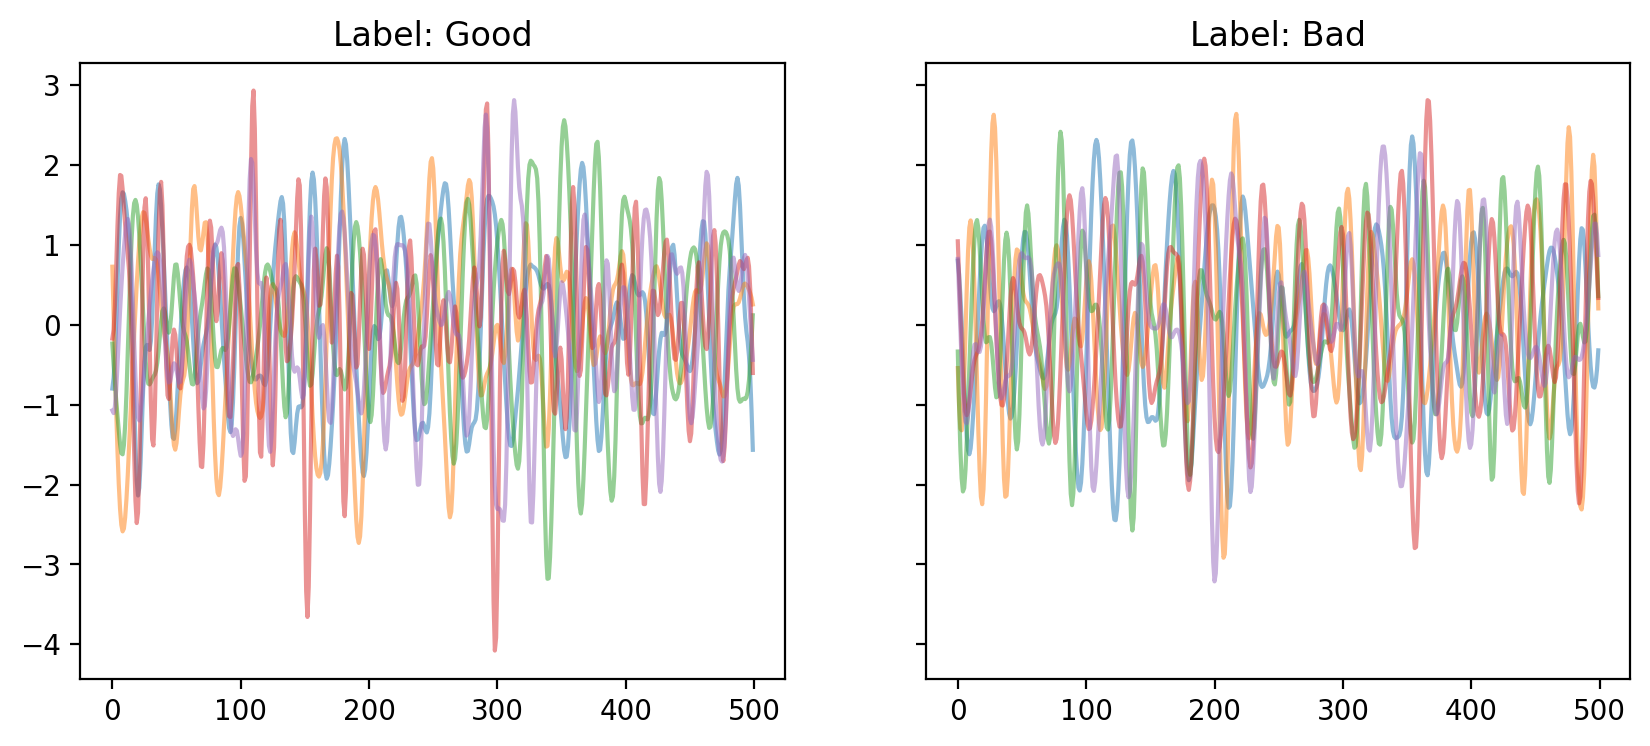

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

x_ = x_train[y_train[:,0]==1]    
axes[0].plot(x_[:5].T, alpha=0.5)
axes[0].set_title("Label: Good")

x_ = x_train[y_train[:,1]==1]    
axes[1].plot(x_[:5].T, alpha=0.5)
axes[1].set_title("Label: Bad");

We can see that it is not easy to discriminate visually between "good" and "bad" examples.

# CNN classifier

Let's start with a simple model that we have seen before for images - a convolutional neural network. 

We follow the example from the [Keras docs](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/), and you can see more details on using CNN to classify timeseries in [Wang et al. 2016](https://arxiv.org/abs/1611.06455).

In [10]:
model = keras.Sequential([
    keras.layers.Reshape((timeseries_length, 1), input_shape=(timeseries_length,)),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 500, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 64)           256       
                                                                 
 batch_normalization_3 (Bat  (None, 500, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 500, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           12352     
                                                                 
 batch_normalization_4 (Bat  (None, 500, 64)           256       
 chNormalization)                                     

In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=["accuracy"],
)

Let's run the training. 
We use two "callbacks":
- `ReduceLROnPlateau` reduces the learning rate when the validation loss does not decrease for 20 epochs (validation loss is computed on 20% of the training data).
- `EarlyStopping` stops the training when the validation loss does not decrease for 50 epochs.

In [12]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]
)

Epoch 1/300
90/90 [==============================] - 8s 69ms/step - loss: 0.5757 - accuracy: 0.6931 - val_loss: 0.7782 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 2/300
90/90 [==============================] - 7s 76ms/step - loss: 0.4620 - accuracy: 0.7760 - val_loss: 0.7391 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 3/300
90/90 [==============================] - 8s 87ms/step - loss: 0.4623 - accuracy: 0.7719 - val_loss: 0.7693 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 4/300
90/90 [==============================] - 9s 99ms/step - loss: 0.4284 - accuracy: 0.7927 - val_loss: 0.8872 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 5/300
90/90 [==============================] - 9s 101ms/step - loss: 0.4053 - accuracy: 0.7986 - val_loss: 0.7012 - val_accuracy: 0.5368 - lr: 0.0010
Epoch 6/300
90/90 [==============================] - 9s 97ms/step - loss: 0.3968 - accuracy: 0.8056 - val_loss: 0.5232 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 7/300
90/90 [==============================] - 9s 102ms/step - 

KeyboardInterrupt: 

In [9]:
model.save("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

In [9]:
model = keras.models.load_model("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "rb") as f:
    history = pickle.load(f)

ValueError: Layer 'conv1d_2' expected 2 variables, but received 0 variables during loading. Expected: ['conv1d_2/kernel:0', 'conv1d_2/bias:0']

Let's see how the CNN model performs on the test data.

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

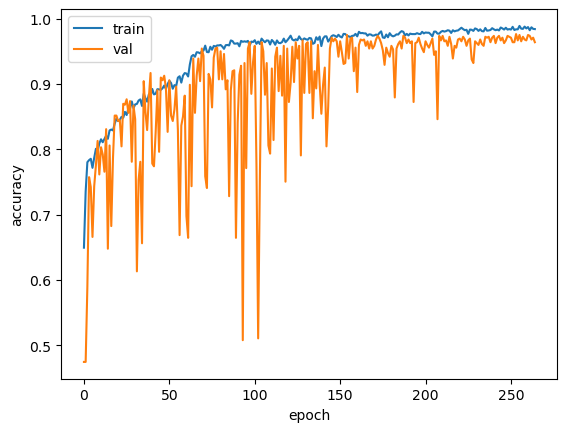

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);

We reached a high test accuracy - 98%. You can see that only in the last few epochs the validation accuracy stabilized.

# Transformer classifier

Our model has two parts: a transformer encoder, and a classifier.

The input to the transformer has shape `(batch size, sequence_length, features)`, where `sequence_length` is the number of time steps and `features` is each input timeseries, which in our case is just one.
This means that the transformer can replace an RNN: the inputs are fully compatible!
We include residual connections, layer normalization, and dropout. The resulting layer can be stacked multiple times.
The projection layers are implemented through a 1D convolution.

In [4]:
def transformer_encoder(input, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(input, input)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + input

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=input.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

Let's stack four transformer-encoders, and then connect them to a FFN classifier.

In [5]:
input = keras.Input(shape=(sequence_length,))
x = keras.layers.Reshape((sequence_length, 1))(input)

# stack four transformer-encoders
for _ in range(4):
    x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.25)
    
# feed-forward classifier
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(input, output)
model.summary()

2024-02-18 13:58:41.019434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 13:58:41.019648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-18 13:58:41.019760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 500, 1)               0         ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 500, 1)               7169      ['reshape[0][0]',             
 iHeadAttention)                                                     'reshape[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 500, 1)               0         ['multi_head_attention[0][

In [6]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

In [7]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/300


2024-02-18 13:58:50.156280: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-18 13:58:50.861841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2024-02-18 13:58:50.928054: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-18 13:58:51.608080: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5678d4ec30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 13:58:51.608107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-02-18 13:58:51.612346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-18 13:58:51.691815: I ./tensorflow/compiler/jit/device_compiler.h:

90/90 [==============================] - 18s 105ms/step - loss: 0.8510 - accuracy: 0.5260 - val_loss: 0.7177 - val_accuracy: 0.5645
Epoch 2/300
90/90 [==============================] - 9s 101ms/step - loss: 0.7584 - accuracy: 0.5806 - val_loss: 0.6752 - val_accuracy: 0.6186
Epoch 3/300
90/90 [==============================] - 9s 102ms/step - loss: 0.7053 - accuracy: 0.6187 - val_loss: 0.6479 - val_accuracy: 0.6491
Epoch 4/300
90/90 [==============================] - 9s 102ms/step - loss: 0.6683 - accuracy: 0.6594 - val_loss: 0.6276 - val_accuracy: 0.6644
Epoch 5/300
90/90 [==============================] - 9s 102ms/step - loss: 0.6402 - accuracy: 0.6781 - val_loss: 0.6135 - val_accuracy: 0.6713
Epoch 6/300
90/90 [==============================] - 9s 102ms/step - loss: 0.6224 - accuracy: 0.6958 - val_loss: 0.6008 - val_accuracy: 0.6865
Epoch 7/300
90/90 [==============================] - 9s 103ms/step - loss: 0.6044 - accuracy: 0.7045 - val_loss: 0.5907 - val_accuracy: 0.6990
Epoch 8/30

In [8]:
model.save("../data/ford_transformer.keras")
with open("../data/ford_transformer_history.p", "wb") as f:
    pickle.dump(history, f)

In [9]:
model = keras.models.load_model("../data/ford_transformer.keras")

In [10]:
model.evaluate(x_test, y_test, verbose=1)

113/113 [==============================] - 4s 34ms/step - loss: 0.1283 - accuracy: 0.9650


[0.12831148505210876, 0.9650097489356995]

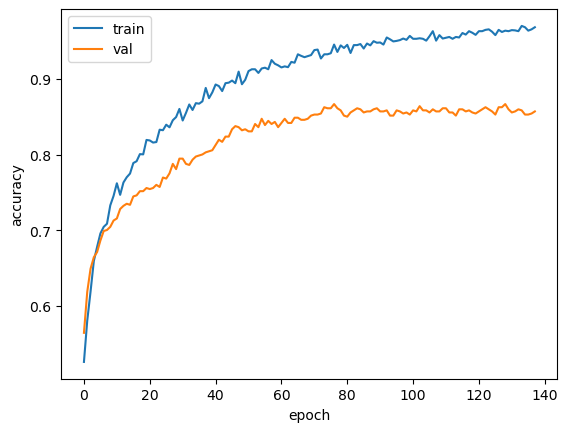

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)